# Setup

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


# Data Wrangling

## Load Dataset

In [2]:
!pip install opendatasets

import opendatasets as od
od.download("https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: farrelballard
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data


100%|██████████| 89.4M/89.4M [00:00<00:00, 133MB/s]


In [3]:
dataset_path = "/content/bitcoin-historical-data/btcusd_1-min_data.csv"
data = pd.read_csv(dataset_path)

## Explore Dataset

In [4]:
data.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [5]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6724281 entries, 0 to 6724280
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Timestamp  6724280 non-null  float64
 1   Open       6724281 non-null  float64
 2   High       6724281 non-null  float64
 3   Low        6724281 non-null  float64
 4   Close      6724281 non-null  float64
 5   Volume     6724281 non-null  float64
dtypes: float64(6)
memory usage: 307.8 MB


In [6]:
print(data.isnull().sum())

Timestamp    1
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


In [7]:
print(data[data.isnull().any(axis=1)])

         Timestamp     Open     High      Low    Close    Volume
6724280        NaN  57854.0  57864.0  57835.0  57835.0  1.353466


In [8]:
# Fix Missing Value using Forward Fill
data = data.fillna(method='ffill')

In [14]:
print(data.iloc[6724278:])

            Timestamp     Open     High      Low    Close    Volume
6724278  1.733443e+09  97044.0  97080.0  97044.0  97057.0  0.053471
6724279  1.733443e+09  96968.0  97092.0  96968.0  97086.0  0.082495
6724280  1.733443e+09  57854.0  57864.0  57835.0  57835.0  1.353466


In [15]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6724281 entries, 0 to 6724280
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Timestamp  6724281 non-null  float64
 1   Open       6724281 non-null  float64
 2   High       6724281 non-null  float64
 3   Low        6724281 non-null  float64
 4   Close      6724281 non-null  float64
 5   Volume     6724281 non-null  float64
dtypes: float64(6)
memory usage: 307.8 MB


In [16]:
# Convert Timestamp to Datetime
data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s')

In [17]:
data.head()

,Timestamp,Open,High,Low,Close,Volume,Datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00


In [18]:
# Reduce granularity to hourly averages
data = data.set_index('Datetime').resample('H').mean().reset_index()

In [19]:
data.head()

,Datetime,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 10:00:00,1.325414e+09,4.58,4.58,4.58,4.58,0.0
1,2012-01-01 11:00:00,1.325417e+09,4.58,4.58,4.58,4.58,0.0
2,2012-01-01 12:00:00,1.325421e+09,4.58,4.58,4.58,4.58,0.0
3,2012-01-01 13:00:00,1.325425e+09,4.58,4.58,4.58,4.58,0.0
4,2012-01-01 14:00:00,1.325428e+09,4.58,4.58,4.58,4.58,0.0


In [20]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113343 entries, 0 to 113342
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Datetime   113343 non-null  datetime64[ns]
 1   Timestamp  112126 non-null  float64       
 2   Open       112126 non-null  float64       
 3   High       112126 non-null  float64       
 4   Low        112126 non-null  float64       
 5   Close      112126 non-null  float64       
 6   Volume     112126 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 6.1 MB


From this, it is evident that the number of data points has been reduced from 6,724,281 to 113,343

This because we want to make the dataset smaller and reduce granularity by making it hourly

In [21]:
print(data.isnull().sum())

Datetime        0
Timestamp    1217
Open         1217
High         1217
Low          1217
Close        1217
Volume       1217
dtype: int64


In [22]:
data = data.fillna(method='ffill').fillna(method='bfill')

In [23]:
print(data[data.isnull().any(axis=1)])  # Display rows with NaNs

Empty DataFrame
Columns: [Datetime, Timestamp, Open, High, Low, Close, Volume]
Index: []


In [24]:
print(data.isnull().sum())

Datetime     0
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


In [25]:
# Normalize selected columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])
data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaled_data

In [26]:
print(np.any(np.isnan(scaled_data)))
print(np.any(np.isinf(scaled_data)))

False
False


In [27]:
print(data.isnull().sum())

Datetime     0
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


In [28]:
data.head()

,Datetime,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 10:00:00,1.325414e+09,0.000004,0.000004,0.000004,0.000004,0.0
1,2012-01-01 11:00:00,1.325417e+09,0.000004,0.000004,0.000004,0.000004,0.0
2,2012-01-01 12:00:00,1.325421e+09,0.000004,0.000004,0.000004,0.000004,0.0
3,2012-01-01 13:00:00,1.325425e+09,0.000004,0.000004,0.000004,0.000004,0.0
4,2012-01-01 14:00:00,1.325428e+09,0.000004,0.000004,0.000004,0.000004,0.0


**Why Normalize Data?**

Normalization (or scaling) is often important in machine learning because many algorithms work better when the features (the input data) are on a similar scale. This helps to prevent features with larger values from dominating the model and ensures that all features contribute equally.

# Prepare Data for LSTM

In [29]:
# Create sequences for training and testing
def create_sequences(data, target_column, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_column])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # Number of timesteps

In [30]:
# Split into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare sequences
X_train, y_train = create_sequences(train_data, target_column=3, seq_length=SEQ_LENGTH)  # Predicting 'Close'
X_test, y_test = create_sequences(test_data, target_column=3, seq_length=SEQ_LENGTH)

# Build LSTM Model

In [31]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 5)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)  # Predicting one value
])

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse', metrics=['mae'])

# Train Model

In [33]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=64,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 124s 85ms/step - loss: 7.8556e-04 - mae: 0.0113 - val_loss: 1.9224e-04 - val_mae: 0.0083
Epoch 2/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 121s 85ms/step - loss: 1.7243e-04 - mae: 0.0070 - val_loss: 2.9235e-04 - val_mae: 0.0135
Epoch 3/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 117s 83ms/step - loss: 1.5836e-04 - mae: 0.0071 - val_loss: 5.4239e-05 - val_mae: 0.0042
Epoch 4/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 143s 84ms/step - loss: 1.6406e-04 - mae: 0.0074 - val_loss: 4.4893e-04 - val_mae: 0.0131
Epoch 5/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 119s 84ms/step - loss: 1.5949e-04 - mae: 0.0073 - val_loss: 2.2179e-04 - val_mae: 0.0128
Epoch 6/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 143s 84ms/step - loss: 1.5299e-04 - mae: 0.0071 - val_loss: 1.6274e-04 - val_mae: 0.0088


# Evaluate and Predict

In [34]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

707/707 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 5.2679e-05 - mae: 0.0064
Test Loss: 0.0002, Test MAE: 0.0088


In [35]:
predictions = model.predict(X_test)

denorm_predictions = scaler.inverse_transform([[0, 0, 0, pred, 0] for pred in predictions.flatten()])[:, 3]
denorm_actuals = scaler.inverse_transform([[0, 0, 0, act, 0] for act in y_test])[:, 3]

707/707 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step


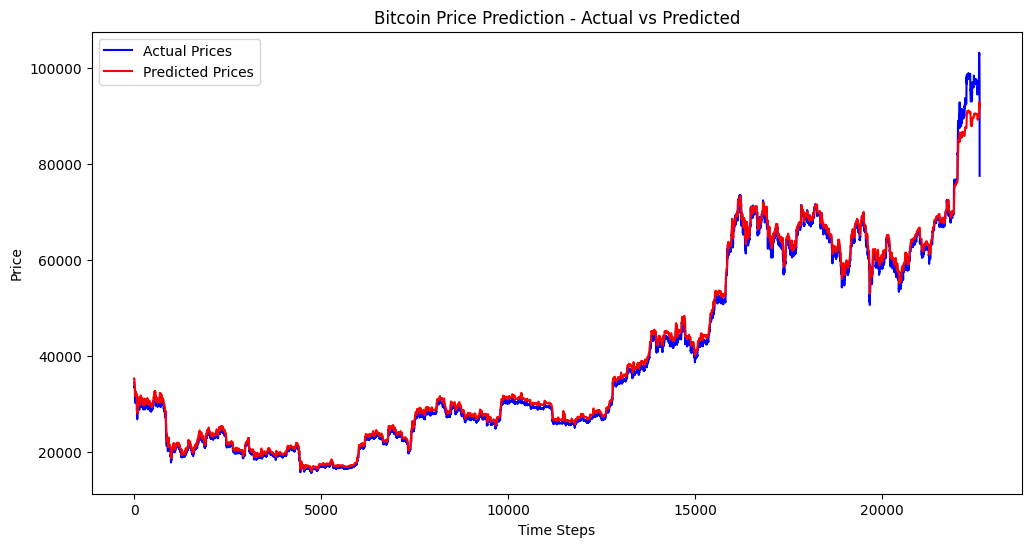

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(denorm_actuals, label='Actual Prices', color='blue')
plt.plot(denorm_predictions, label='Predicted Prices', color='red')
plt.title('Bitcoin Price Prediction - Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

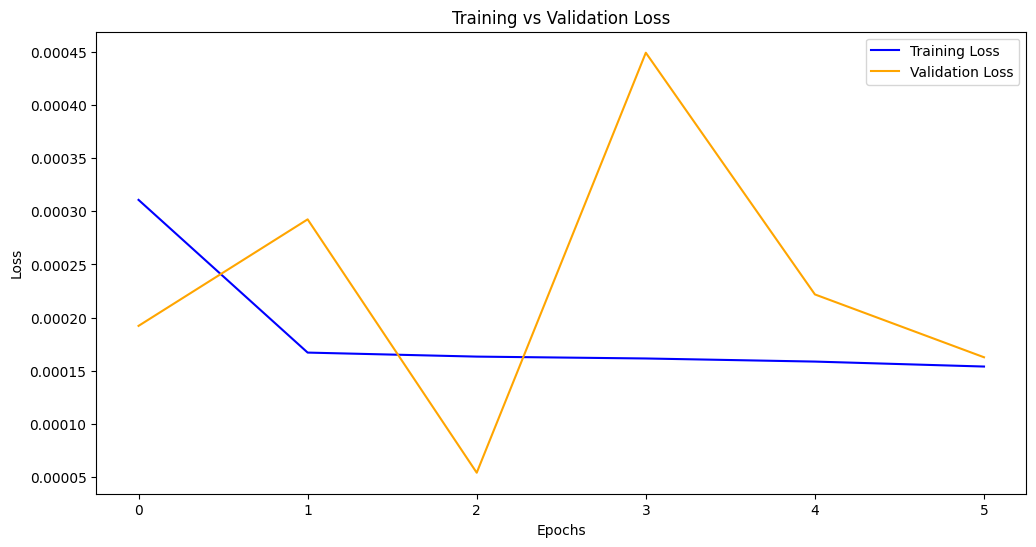

In [37]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

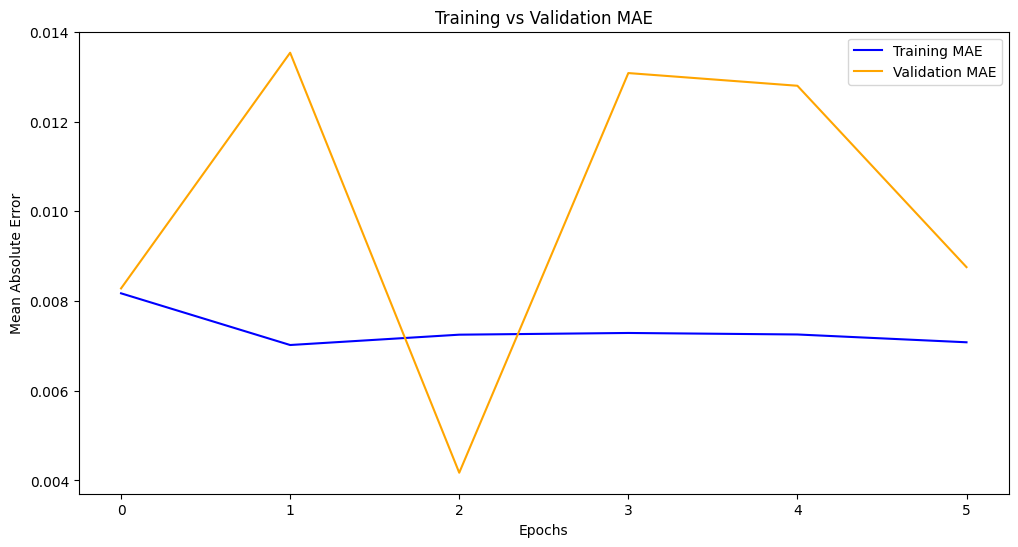

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE', color='blue')
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# Metrices

In [40]:
from sklearn.metrics import r2_score

r2 = r2_score(denorm_actuals, denorm_predictions)
print(f"R-squared: {r2:.4f}")

R-squared: 0.9957


In [41]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(denorm_actuals, denorm_predictions)
print(f"MAPE: {mape:.2f}%")

MAPE: 2.35%


# Conclusion

**R-squared: 0.9957**

Meaning: This value indicates that your model explains approximately 99.57% of the variance in Bitcoin prices based on the features you used. In simpler terms, it suggests that your model's predictions are very closely aligned with the actual price movements.
Interpretation: An R-squared value of 0.9957 is exceptionally high, suggesting a very strong fit between your model's predictions and the actual data. This typically indicates a well-performing model for this specific dataset.

**MAPE: 2.35%**

Meaning: This value indicates that, on average, your model's predictions are off by about 2.35% from the actual Bitcoin prices.
Interpretation: A MAPE of 2.35% is considered relatively low, which is a positive sign. It means your model's predictions are generally quite accurate, with an average error of just over 2%.

# Save Model

In [39]:
model.save('/content/drive/MyDrive/Bitcoin/bitcoin_lstm.keras')